In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

In [2]:
def generate_circle_sample_data(r, n, sigma):

    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    
    return x, y

In [87]:
n_samples = 100
sigma=0.4 

x1, y1 = generate_circle_sample_data(2, n_samples, sigma)
x2, y2 = generate_circle_sample_data(4, n_samples, sigma)
x3, y3 = generate_circle_sample_data(6, n_samples, sigma)

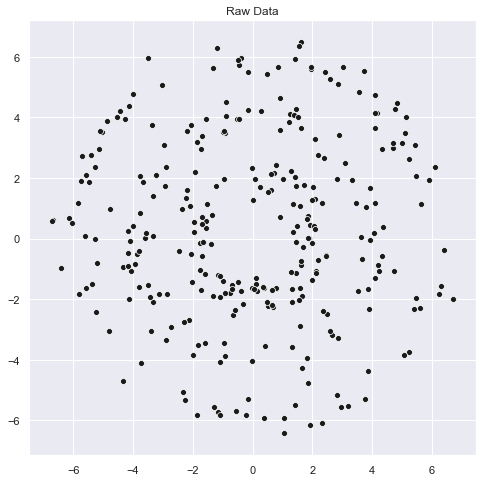

In [88]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(x=x1, y=y1, ax=ax, color='k')
sns.scatterplot(x=x2, y=y2, ax=ax, color='k')
sns.scatterplot(x=x3, y=y3, ax=ax, color='k')

ax.set(title='Raw Data');

In [89]:
n_labeled = 10
number_classes = 3

q1, p1 = generate_circle_sample_data(2, n_labeled, sigma)
q2, p2 = generate_circle_sample_data(4, n_labeled, sigma)
q3, p3 = generate_circle_sample_data(6, n_labeled, sigma)

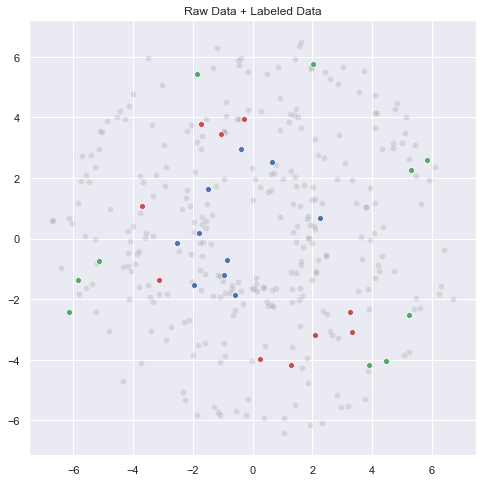

In [90]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(x=x1, y=y1, ax=ax, color='k', alpha=0.1)
sns.scatterplot(x=x2, y=y2, ax=ax, color='k', alpha=0.1)
sns.scatterplot(x=x3, y=y3, ax=ax, color='k', alpha=0.1)

sns.scatterplot(x=q1, y=p1, ax=ax, color='b')
sns.scatterplot(x=q2, y=p2, ax=ax, color='r')
sns.scatterplot(x=q3, y=p3, ax=ax, color='g')

ax.set(title='Raw Data + Labeled Data');

In [91]:
x = np.concatenate([x1, x2, x3, q1, q2, q3]).reshape(-1, 1)
y = np.concatenate([y1, y2, y3, p1, p2, p3]).reshape(-1, 1)

In [92]:
data_matrix = np.concatenate([x, y], axis=1)

In [93]:
from sklearn.neighbors import kneighbors_graph

adjacency_matrix_s = kneighbors_graph(X=data_matrix,n_neighbors=3)

In [94]:
adjacency_matrix = scipy.sparse.csr_matrix.todense(adjacency_matrix_s)

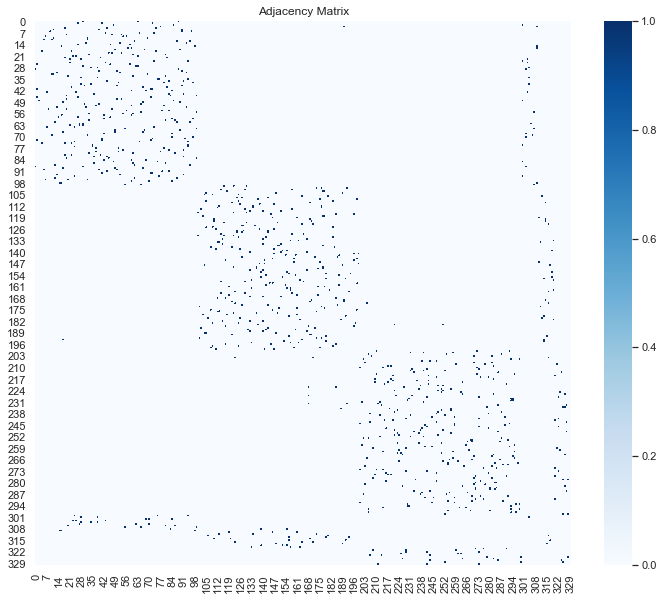

In [95]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(adjacency_matrix, ax=ax, cmap='Blues')

ax.set(title='Adjacency Matrix');

In [96]:
from scipy.sparse.csgraph import laplacian

graph_laplacian_s = laplacian(csgraph=adjacency_matrix_s, normed=False)

In [97]:
graph_laplacian = scipy.sparse.csr_matrix.todense(graph_laplacian_s)

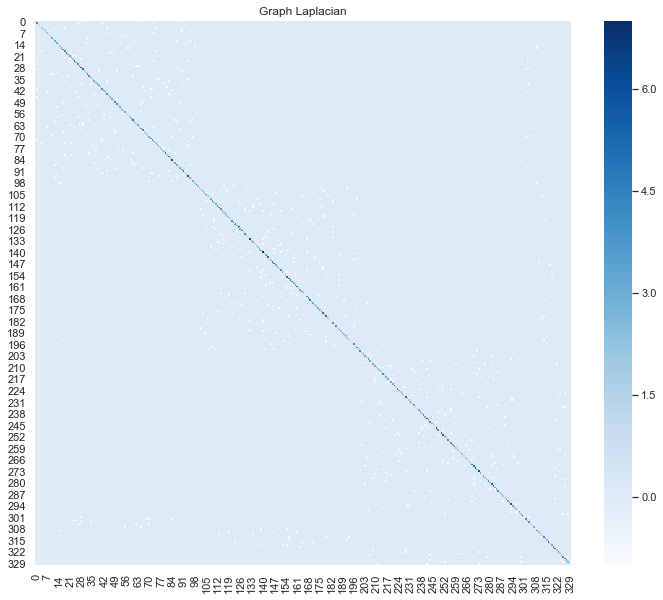

In [106]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(graph_laplacian, ax=ax, cmap='Blues')

ax.set(title='Graph Laplacian');